In [1]:
#  DEMO script (python version) for pyseisdl
#  
#  Copyright (C) 2022 Yangkang Chen
#  
#  This program is free software: you can redistribute it and/or modify
#  it under the terms of the GNU General Public License as published
#  by the Free Software Foundation, either version 3 of the License, or
#  any later version.
#
#  This program is distributed in the hope that it will be useful,
#  but WITHOUT ANY WARRANTY; without even the implied warranty of
#  MERCHANTABILITY or FITNESS FOR A PARTICULAR PURPOSE.  See the
#  GNU General Public License for more details: http://www.gnu.org/licenses/
#  Reference: Chen, Y. (2020). Fast dictionary learning for noise attenuation of multidimensional seismic data. Geophysical Journal International, 222(3), 1717-1727.
#             Wang, H., Chen, W., Zhang, Q., Liu, X., Zu, S., & Chen, Y. (2020). Fast dictionary learning for high-dimensional seismic reconstruction. IEEE Transactions on Geoscience and Remote Sensing, 59(8), 7098-7108.


## Generate synthetic data


In [2]:

import numpy as np
import matplotlib.pyplot as plt
import src.denoise as dl #dl: dictionary learning
from src import snr
import time
## generate the synthetic data
a1=np.zeros([300,20])
[n,m]=a1.shape
a3=np.zeros([300,20])
a4=np.zeros([300,20])

k=-1;
a=0.1;
b=1;
pi=np.pi

ts=np.arange(-0.055,0.055+0.002,0.002)
b1=np.zeros([len(ts)])
b2=np.zeros([len(ts)])
b3=np.zeros([len(ts)])
b4=np.zeros([len(ts)])

for t in ts:
    k=k+1;
    b1[k]=(1-2*(pi*30*t)*(pi*30*t))*np.exp(-(pi*30*t)*(pi*30*t));
    b2[k]=(1-2*(pi*40*t)*(pi*40*t))*np.exp(-(pi*40*t)*(pi*40*t));
    b3[k]=(1-2*(pi*40*t)*(pi*40*t))*np.exp(-(pi*40*t)*(pi*40*t));
    b4[k]=(1-2*(pi*30*t)*(pi*30*t))*np.exp(-(pi*30*t)*(pi*30*t));

t1=np.zeros([m],dtype='int')
t3=np.zeros([m],dtype='int')
t4=np.zeros([m],dtype='int')
for i in range(m):
  t1[i]=np.round(140);
  t3[i]=np.round(-6*i+180);
  t4[i]=np.round(6*i+10);
  a1[t1[i]:t1[i]+k+1,i]=b1; 
  a3[t3[i]:t3[i]+k+1,i]=b1; 
  a4[t4[i]:t4[i]+k+1,i]=b1; 

temp=a1[0:300,:]+a3[0:300,:]+a4[0:300,:];

shot=np.zeros([300,20,20])
for j in range(20):
    a4=np.zeros([300,20]);
    for i in range(m):
    	t4[i]=np.round(6*i+10+3*j); 
    	a4[t4[i]:t4[i]+k+1,i]=b1;
  
    	t1[i]=np.round(140-2*j);
    	a1[t1[i]:t1[i]+k+1,i]=b1;

    shot[:,:,j]=a1[0:300,:]+a3[0:300,:]+a4[0:300,:];

dc=shot

## add noise
[n1,n2,n3]=dc.shape
np.random.seed(201415)
n=0.2*np.random.randn(n1,n2,n3);
dn=dc+n;
print(np.std(dn))



0.2998256797949811


## Applying Dictionary Learning

In [3]:

param={'T':2,'niter':10,'mode':1,'K':64};
mode=1;l1=4;l2=4;l3=4;s1=2;s2=2;s3=2;perc=1; 
t1 = time.time()
[d1,D,G,dct]=dl.sgk_denoise(dn,mode,[l1,l2,l3],[s1,s2,s3],perc,param);
t2 = time.time()
print('SGK takes %.2g seconds'%(t2-t1));
noi1=dn-d1;


## compare SNR
print('SNR of Noisy is %g'%snr(dc,dn,2));
print('SNR of SGK is %g'%snr(dc,d1,2));



SGK takes 55 seconds
SNR of Noisy is 0.962195
SNR of SGK is 14.2882


## Plotting Results


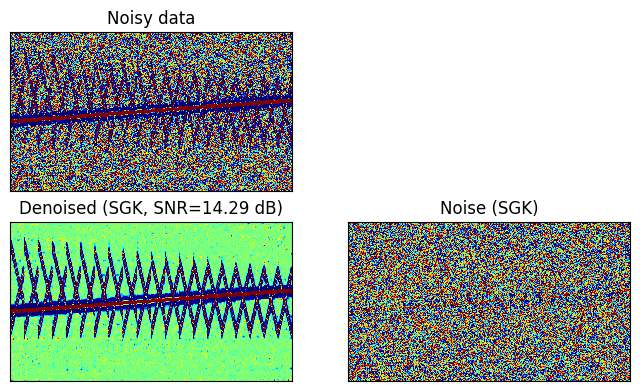

In [4]:
fig = plt.figure(figsize=(8, 7))
ax=fig.add_subplot(3, 2, 1)
plt.imshow(dn.transpose(0,2,1).reshape(n1,n2*n3),cmap='jet',clim=(-0.1, 0.1),aspect='auto');ax.set_xticks([]);ax.set_yticks([]);
plt.title('Noisy data');
ax=fig.add_subplot(3, 2, 3)
plt.imshow(d1.reshape(n1,n2*n3,order='F'),cmap='jet',clim=(-0.1, 0.1),aspect='auto');ax.set_xticks([]);ax.set_yticks([]);
plt.title('Denoised (SGK, SNR=%.4g dB)'%snr(dc,d1,2));
ax=fig.add_subplot(3, 2, 4)
plt.imshow(noi1.transpose(0,2,1).reshape(n1,n2*n3),cmap='jet',clim=(-0.1, 0.1),aspect='auto');ax.set_xticks([]);ax.set_yticks([]);
plt.title('Noise (SGK)');
plt.show()